In [1]:
# !pip install pandas matplotlib

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
logs_file = 'workload.log'

def read_epochs_data(filename):
    with open(filename, 'r') as file:
        epoch_data = []
        grabbing_data = False
        for line in file:
            line = line.strip()
            if line.startswith("====================="):
                if grabbing_data:
                    yield epoch_data
                    epoch_data = []
                    grabbing_data = False
            elif grabbing_data:
                epoch_data.append(line)
            else:
                grabbing_data = True
                epoch_data.append(line)

In [4]:
def extract_column_family(lines):
    
    # Initialize variables to store column family data
    column_family_data = {"Levels": []}
    sst_files = {}
    i = 0

    # Process each line
    while i < len(lines):
        line = lines[i]
        # Check if the line contains column family data
        if line.startswith("Column Family Name"):
            key_val = line.split(',')
            column_family_data["Column Family Name"] = key_val[0].split(':')[1].strip().strip(',')
            column_family_data["Size"] = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            column_family_data["Files Count"] = int(key_val[2].split(':')[1].strip().strip(','))
        if "Level:" in line:
            key_val = line.strip().split(',')
            level = int(key_val[0].split(":")[1].strip().strip(','))
            level_size = int(key_val[1].split(':')[1].strip().strip(',').strip(' bytes'))
            level_files_count = int(key_val[2].split(':')[1].strip().strip(','))

            key_val_sst_files = lines[i+1].split('],')[:-1]
            sst_files = []
            
            for sst_file_string in key_val_sst_files:
                # Extract SST file details
                file_number = int(sst_file_string.split(":")[0].split("[#")[1].strip())
                file_details = sst_file_string.split(":")[1].strip().split()
                file_size = int(file_details[0].strip())
                smallest_key = int(file_details[1].strip(',').strip('('))
                largest_key = int(file_details[2].strip(')'))
                entries_count = int(file_details[3].strip(']'))

                sst_files.append({
                    "FNo": file_number,
                    "FileSize": file_size,
                    "SmallesKey": smallest_key,
                    "LargestKey": largest_key,
                    "EntriesCount": entries_count
                })
            
            if len(sst_files) > 0:
                column_family_data["Levels"].append({
                    "Level": level,
                    "LevelSize": level_size,
                    "LevelFilesCount": level_files_count,
                    "SSTFiles": sst_files
                })
            i += 1

        i += 1

    return column_family_data

In [5]:
def extract_total_write_bytes(one_epoch):
    """
    rocksdb.compact.read.bytes
    rocksdb.compact.write.bytes
    rocksdb.flush.write.bytes
    """
    read_bytes = 0
    write_bytes = 0

    for line in one_epoch:
        if line.startswith("rocksdb.compact.read.bytes"):
            read_bytes += int(line.split(':')[1])
        elif line.startswith('rocksdb.compact.write.bytes') or line.startswith('rocksdb.flush.write.bytes'):
            write_bytes += int(line.split(':')[1])
    
    return read_bytes, write_bytes

In [6]:
# Find compaction debt, write amplification and entries per file

def compaction_debt(cfd_data):
    # Iterate through levels, summing up entries count for levels except the last one
    compaction_debt = 0

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])
    
    for level in sorted_levels[:-1]:
        for sst_file in level['SSTFiles']:
            compaction_debt += sst_file['EntriesCount']

    return compaction_debt

def write_amplification_debt(cfd_data):
    entries_list = list()

    sorted_levels = sorted(cfd_data['Levels'], key=lambda x: x['Level'])

    for level in sorted_levels[:-1]:
        for sst_file in level["SSTFiles"]:
            entries_list.append(sst_file['EntriesCount'])
    
    return sum([entries * (len(entries_list) - index + 1) for index, entries in enumerate(entries_list, 1)])

def avg_entries_per_SST_file(cfd_data):
    total_entries = 0
    total_sst_files = 0

    # Iterate through each level
    for level in cfd_data['Levels']:
        # Iterate through SST files in each level
        for sst_file in level['SSTFiles']:
            total_entries += sst_file['EntriesCount']
            total_sst_files += 1
    
    return total_entries / total_sst_files

In [7]:
first = True

stats = list()

for one_epoch in read_epochs_data(logs_file):
    if first: first = False
    else:
        cf_data = extract_column_family(one_epoch)
        read_bytes, write_bytes = extract_total_write_bytes(one_epoch)
        one_epoch_cd = compaction_debt(cf_data)
        one_epoch_wa = write_amplification_debt(cf_data)
        one_epoch_epf = avg_entries_per_SST_file(cf_data)

        stats.append(
            {
                "CompactionDebt": one_epoch_cd,
                "WriteAmpDebt": one_epoch_wa,
                "AvgEntriesPerSST": one_epoch_epf,
                "FilesCount": cf_data["Files Count"],
            }
        )

In [8]:
stats

[{'CompactionDebt': 783175,
  'WriteAmpDebt': 23966844,
  'AvgEntriesPerSST': 12820.52564102564,
  'FilesCount': 78},
 {'CompactionDebt': 752753,
  'WriteAmpDebt': 22172832,
  'AvgEntriesPerSST': 12965.075949367088,
  'FilesCount': 79},
 {'CompactionDebt': 775786,
  'WriteAmpDebt': 23530713,
  'AvgEntriesPerSST': 12771.634146341463,
  'FilesCount': 82},
 {'CompactionDebt': 797235,
  'WriteAmpDebt': 24853165,
  'AvgEntriesPerSST': 13033.207317073171,
  'FilesCount': 82},
 {'CompactionDebt': 711145,
  'WriteAmpDebt': 20023954,
  'AvgEntriesPerSST': 12848.95294117647,
  'FilesCount': 85},
 {'CompactionDebt': 734438,
  'WriteAmpDebt': 21365695,
  'AvgEntriesPerSST': 12821.310344827587,
  'FilesCount': 87},
 {'CompactionDebt': 755374,
  'WriteAmpDebt': 22598694,
  'AvgEntriesPerSST': 12768.426966292134,
  'FilesCount': 89},
 {'CompactionDebt': 777670,
  'WriteAmpDebt': 23933049,
  'AvgEntriesPerSST': 12874.288888888888,
  'FilesCount': 90},
 {'CompactionDebt': 796965,
  'WriteAmpDebt': 2533

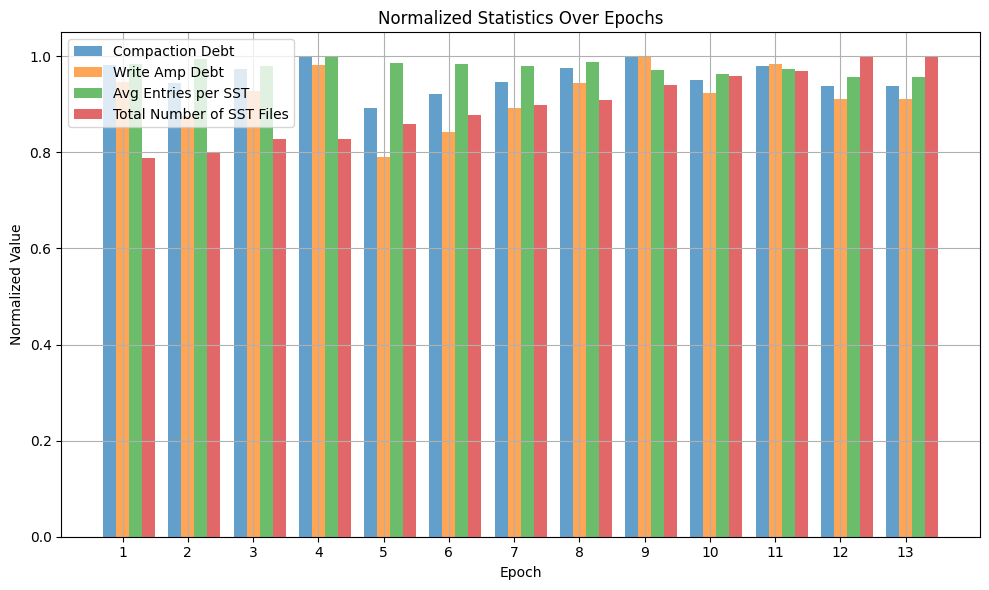

In [11]:
epochs = range(1, 14)

compaction_debt_range = [element["CompactionDebt"] for element in stats]
write_amp_debt = [element["WriteAmpDebt"] for element in stats]
avg_entries_per_sst = [element["AvgEntriesPerSST"] for element in stats]
sst_files_count = [element["FilesCount"] for element in stats]

# Normalize the values
compaction_debt_range_norm = [val / max(compaction_debt_range) for val in compaction_debt_range]
write_amp_debt_norm = [val / max(write_amp_debt) for val in write_amp_debt]
avg_entries_per_sst_norm = [val / max(avg_entries_per_sst) for val in avg_entries_per_sst]
sst_files_count_norm = [val / max(sst_files_count) for val in sst_files_count]

bar_width = 0.2  # Width of each bar

plt.figure(figsize=(10, 6))

# Adjust the position of bars for each epoch
bar_positions_compaction = np.arange(len(epochs))
bar_positions_write_amp = [pos + bar_width for pos in bar_positions_compaction]
bar_positions_avg_entries = [pos + bar_width*2 for pos in bar_positions_compaction]
bar_positions_sst_files = [pos + bar_width*3 for pos in bar_positions_compaction]

# Compaction Debt
plt.bar(bar_positions_compaction, compaction_debt_range_norm, width=bar_width, label='Compaction Debt', alpha=0.7)

# Write Amplification Debt
plt.bar(bar_positions_write_amp, write_amp_debt_norm, width=bar_width, label='Write Amp Debt', alpha=0.7)

# Average Entries per SST
plt.bar(bar_positions_avg_entries, avg_entries_per_sst_norm, width=bar_width, label='Avg Entries per SST', alpha=0.7)

# Average Entries per SST
plt.bar(bar_positions_sst_files, sst_files_count_norm, width=bar_width, label='Total Number of SST Files', alpha=0.7)


# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Normalized Value')
plt.title('Normalized Statistics Over Epochs')
plt.xticks(bar_positions_compaction + bar_width, epochs)  # Ensure all epochs are displayed on x-axis
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()